# Python Machine Learning: Regression

We'll begin our foray into machine learning with **regression**. Regression is a **supervised** problem in which we use a set of features (also called independent variables or predictors) to try to predict a continuous output, or a real valued number. This is a supervised problem because we have an existing dataset in which we know what the actual outputs are for a set of samples. By showing a model enough examples, the hope is that the model can be trained to predict the output value given just the set of features, where the prediction is as close to the real value as possible.

There are many ways to perform the task of regression. In this lesson, we'll focus on linear regression, and specifically ordinary least squares (OLS), which is one of the most foundational models in statistics and machine learning.

## Auto MPG Dataset

We're going to use the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG) from UCI's machine learning repository. The Auto MPG dataset contains information on city-cycle fuel consumption in miles per gallon for various types of cars. Our goal is to predict the miles per gallon of different car make and models using 7 predictors. 

The `auto-mpg` dataset is stored in a `.csv` file that can be accessed from the UCI repository. We've obtained a copy and made a few modifications, which we've stored in the `data` folder. We'll use `pandas` to load in the dataset by specifying the correct path. We'll start by performing some exploratory data analysis, and then build an OLS model.

First, let's import (or install) some packages we'll need.

In [1]:
# Run this cell if you don't have these packages installed
!pip install numpy pandas scikit-learn matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, let's load the `auto-mpg` dataset using `pandas`:

In [3]:
data = pd.read_csv('../data/auto-mpg.csv')
# Check out the first few rows
data.head()

,car name,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
4,ford torino,17.0,8,302.0,140,3449,10.5,70,1


Below is a "data dictionary", containing information about each of the variables in the dataset.

| Feature     | Data Type |
| ----------- | -------- |
| **car name** | string (unique for each instance) | 
| **mpg**     | continuous |
| **cylinders** | multi-valued discrete |
| **displacement** | continuous |
| **horsepower** |  continuous | 
| **weight** | continuous | 
| **acceleration** | continuous | 
| **model year** |  multi-valued discrete | 
| **origin** |  multi-valued discrete | 

## Exploratory Data Analysis

Let's start by getting familiar with our data. This is an important first step before jumping into any modeling.

How many samples in the dataset do we have?

In [4]:
data.shape

(392, 9)

This is a pretty small dataset.

Let's look at the distribution of the target variable:

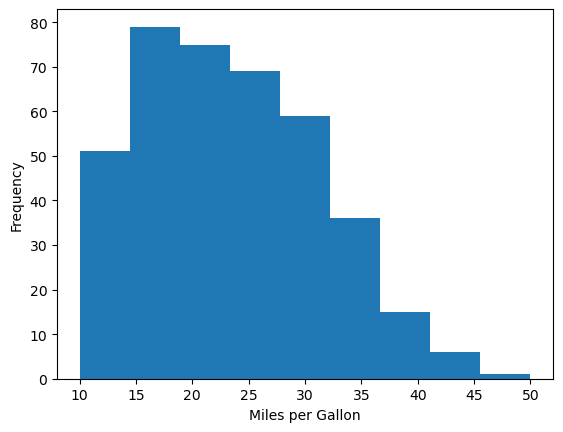

In [5]:
ax = data['mpg'].hist(grid=False, bins=np.linspace(10, 50, 10))
ax.set_xlabel('Miles per Gallon')
ax.set_ylabel('Frequency')
plt.show()

How about how the MPG correlates with the predictors? We can use the `corr()` function to do this:

In [6]:
data.corr()

/var/folders/sy/_bbz4lwx7j79hkfq676xt87m0000gn/T/ipykernel_43478/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


Some variables are pretty strongly correlated with miles per gallon, so there may be some predictive signal here.

---
### Challenge 1: More EDA

Create the following plots, or examine the following distributions, while exploring your data:

1. A histogram of the displacement.
2. A histogram of the horsepower.
3. A histogram of the weight.
4. A histogram of the acceleration.
5. What are the unique model years, and their counts?
6. What are the unique origin values, and their counts?

---

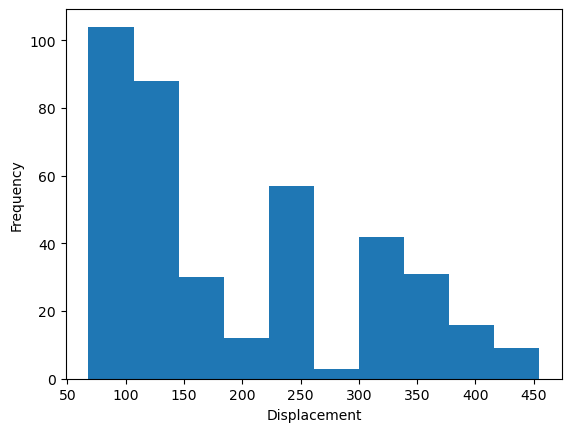

In [7]:
ax = data['displacement'].hist(grid=False)
ax.set_xlabel('Displacement')
ax.set_ylabel('Frequency')
plt.show()

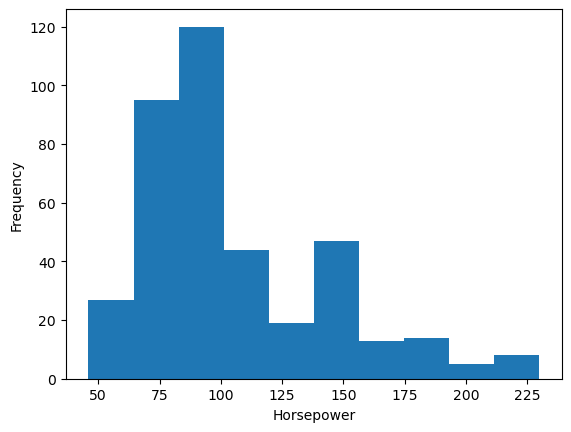

In [8]:
ax = data['horsepower'].hist(grid=False)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Frequency')
plt.show()

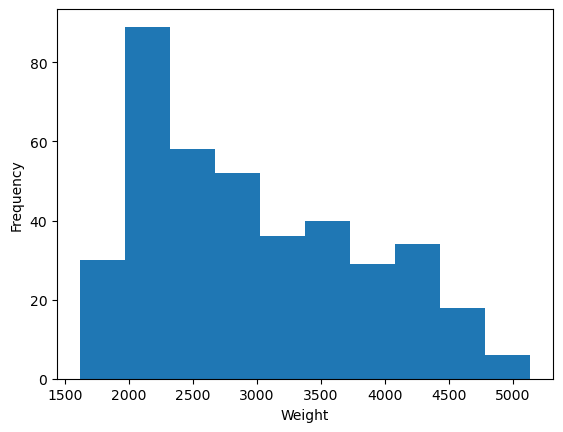

In [9]:
ax = data['weight'].hist(grid=False)
ax.set_xlabel('Weight')
ax.set_ylabel('Frequency')
plt.show()

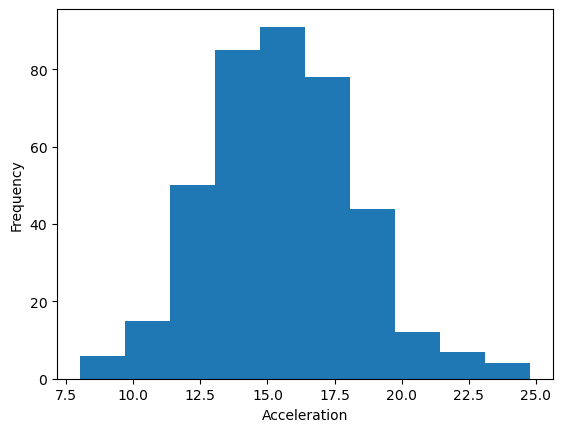

In [10]:
ax = data['acceleration'].hist(grid=False)
ax.set_xlabel('Acceleration')
ax.set_ylabel('Frequency')
plt.show()

In [11]:
data['model year'].value_counts().sort_index()

70    29
71    27
72    28
73    40
74    26
75    30
76    34
77    28
78    36
79    29
80    27
81    28
82    30
Name: model year, dtype: int64

In [12]:
data['origin'].value_counts().sort_index()

1    245
2     68
3     79
Name: origin, dtype: int64

## Creating Train and Test Splits

Next, we'll want to split our dataset into training and test data. When creating the model, we need to make sure it only sees the training data. Then, we can examine how well it **generalizes** to data it hasn't seen before. The train and test split is a foundational concept in machine learning. Be sure you're confident you understand why we do this before moving forward!

A dataset is often broken up into a feature set, or **design matrix** (typically with the variable name `X`) as well as the target or response variable `y`. Both have $D$ samples, but the design matrix will have a second dimension indicating the number of features we're using for prediction.

In this case, we'll extract the output variable `mpg` from the data frame to make the `X` and `y` variables. We use a capital `X` to denote it is a `matrix` or 2-D array, and use a lowercase `y` to denote that it is a `vector`, or 1-D array.

In [13]:
# Remove the response variable and car name
X = data.drop(columns=['car name', 'mpg'])
# Assign response variable to its own variable
y = data['mpg'].astype(np.float64)
# Confidence check
print(X.shape)
print(y.shape)

(392, 7)
(392,)


Now, we perform the train/test split. The package `scikit-learn` is the most commonly used package for machine learning in Python. It provides a function we can easily use to perform this split. Let's import it:

In [14]:
from sklearn.model_selection import train_test_split

We commonly do an 80/20 split, where 80% of the data is used for training, and the remaining 20% is used for testing. We can customize this using the parameters of the `train_test_split` function, which you can find in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We typically split the data randomly. However, sometimes we want this random split to occur in a *reproducible* fashion. This might be when we're testing our code, and want the same random split every time. Or, during a workshop, when we want all participants to get the same split, so that the results look the same for everyone. A reproducible random fit can be done by setting the `random_state`, which is an input argument to `train_test_split`. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [16]:
print(f'X train shape: {X_train.shape}; y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}; y test shape: {y_test.shape}')

X train shape: (313, 7); y train shape: (313,)
X test shape: (79, 7); y test shape: (79,)


Now that we've performed the split, let's train the model!

## Building the Linear Regression Model

There are numerous machine learning models that can be used to model data and generate powerful predictions. These vary widely in the types of algorithms and statistical techniques that are used when building these models. Some models are purposefully built for regression problems, while others are more suited towards classification. Many models can also be used for both sets of problems with small tweaks to their algorithms.

For our dataset, we'll start with the most basic (and probably most common) regression model: **linear regression, specifically Ordinary Least Squares (OLS)**. Although it's somewhat simple in structure (compared to, for example, a neural network), linear regression is a very powerful model in its own right and can be effective when applied to many regression problems.

### What is Ordinary Least Squares?

At a high level, linear regression is nothing more than finding the best straight line, or line of best fit through a set of data points that most accurately captures the pattern that exists within those data points.

The most common picture people have of OLS is in the univariate case (2-D), which looks something like this:

![linear-regression](../images/linear_regression_line.png)

Specifically, we have *one* feature trying to predict an output. There are many points pertaining to the training samples, and we try and choose the right line that is as close to all the points as possible.

However, we rarely predict with only a single feature! We're mostly in the multivariate case. In this scenario, where have many "independent variable" axes, but still one dependent variable axis. The "line" in this case turns into a **hyperplane** which tries to capture as much of the information about the multi-dimensional data points as possible:

![linear-regression](../images/linear_regression_hyperplane.jpeg)

In the above example, we have two features trying to predict a third dependent variable. This is as far as we can go with visualizing OLS, because humans have a hard time visualizations higher dimensions. But the intuition is basically the same: we're trying to pick a hyperplane that minimizes the distances to the data samples.

When we learn an OLS model, we effectively are trying to choose the slope values (also called the weights). These are often depicted mathematically as the $\beta$ values. There is additionally an intercept term (also called the bias term), which is really just a special case of a weight, generally denoted as $\beta_0$. The univariate equation is probably familiar to a lot of you:


$$
\begin{align}
y &= mx + b \\
  &= \beta_0 + \beta_1 X_1
\end{align}$$

You may be more familiar with the $y=mx+b$ formulation, in which $m$ is the slope, and $b$ is the intercept. This is how we specify a line. All we're doing in the second line is rewriting the notation: we're calling the intercept $\beta_0$, and the slope $\beta_1$. We also call the feature $X_1$. We're doing this because, when we have $P$ features (i.e., the multivariate case), this can be written as:

$$Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_P X_P$$

The goal of linear regression, then, is to find a combination of these $\beta_i$ values such that we pass through or as close to as many data points as possible. In other words, we are trying to find the values of $\beta$ that reduce or minimize the aggregate distance between our linear model and the data points. 

We can formalize this into an optimization problem and pursue a strategy that is known in machine learning as minimizing the **cost function** or **objective function** or **loss**. In the case of linear regression, the cost function we are trying to minimize is the **mean squared error (MSE)** function:

$$\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2$$

where:
* $i$ refers to the data sample,
* $N$ is the number of samples,
* $y_i$ is the real value of the $i$th data samples,
* $\hat{y}_i$ is the predicted value of the $i$th data sample, obtained from the linear model.

This is where the name OLS comes from: we're trying to find the "least squares" solution. It's "ordinary" because we're making pretty simple assumptions on the model (there are variants of OLS, in which case they are no longer "ordinary").

So, to summarize:
* We're trying to find the best linear model for the data;
* Finding the best linear model means finding the right $\beta_i$ values;
* We go about choosing these values by minimizing the mean squared error.
The hope is, then, that these $\beta_i$ values are good for **generalization performance**.

## OLS in Practice

The package `scikit-learn` makes it very easy to train a linear regression model. In general, `scikit-learn` models follow the same structure:
* Import the model you want to train (here, `LinearRegression`).
* Create an object for that model with chosen settings. This is *not* training the model. For example, in linear regression, you may choose a linear regression object that does or does not fit an intercept term (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) for more details).
* Train the model using the `fit()` function, passing in the training data.
* Evaluate the model on new data using the `predict()` and `score()` functions.
* Examine the fitted coefficients using attributes (`coef_` and `intercept_`).

Let's train the linear regression model using `scikit-learn`.

In [17]:
# Import the model we want from sklearn's linear model module
from sklearn.linear_model import LinearRegression

In [18]:
# Create an object for the model
# We use the default settings
model = LinearRegression()

In [19]:
# Train the model using the fit function
model.fit(X_train, y_train)

LinearRegression()

We're done with training! That was pretty easy. Now, let's evaluate the model on new data.

## Evaluating a Model

When evaluating models, it's helpful to look at how it performs on both the training and test data, separately. This gives us a sense of the generalization gap, or how much we overfit to our data. If that gap is large, that means we need to make adjustments to the model in order to make sure it learns patterns that generalize well. 

For regression models, the `score()` method returns the amount of variance in the output variable that can be explained by the model predictions. This is known as $R^2$, or R-squared. It has a maximum of 1, with 1 being better predictive performance. There are many other performance metrics that can be used when predicting continuous variables.

Let's look at the $R^2$ for the training data:

In [20]:
print(f'Training R^2: {model.score(X_train, y_train)}')

Training R^2: 0.8317921346660861


And the test data:

In [21]:
print(f'Test R^2: {model.score(X_test, y_test)}')

Test R^2: 0.7356060087557543


We can see here that there is pretty good predictive performance, with a noticeable generalization gap.

Another common metric used in regression plots is the **Root Mean Squared Error (RMSE)**. This can be calculated by simply taking the square root of the MSE. In our case, we can intrepret this as the mean error made when predicting `mpg`, as RMSE is measured in the same units as the target variable.

We can get a RMSE function from `scikit-learn`, but to run it, we'll need to get predictions for each sample using the `predict()` function:

In [22]:
# Import the mean squared error function
from sklearn.metrics import mean_squared_error

In [23]:
# Obtain predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [24]:
print(f'Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}')

Train RMSE: 3.2659803258467326


In [25]:
print(f'Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Test RMSE: 3.552691117032178


We can also look at the MSE directly:

In [26]:
print(f'Train MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_pred)}')

Train MSE: 10.666627488817928
Test MSE: 12.621614173039344


It can be hard to try and assess model performance from MSE or RMSE directly, which is why people often use $R^2$ to evaluate predictive performance.

---
### Challenge 2: Mean Absolute Error

Another commonly used metric in regression is the **Mean Absolute Error (MAE)**. As the name suggests, this can be calculated by taking the mean of the absolute errors. Calculate the mean absolute error on the training and test data with your trained model. We've imported the MAE for you below:

---

In [27]:
from sklearn.metrics import mean_absolute_error as mae
# YOUR CODE HERE
# Remove the response variable and car name
X = data.drop(columns=['car name', 'mpg'])
# Assign response variable to its own variable
y = data['mpg'].astype(np.float64)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [29]:
model = LinearRegression()

In [30]:
model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [32]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_error(y_test, y_test_pred))

2.485653695583297
2.8228755709493765


## Interpreting a Model

The nice thing about linear models is that they're seen as "interpretable". That is, we can go back  and look at the resulting $\beta$ coefficients and exactly say what the model suggests is the relationship between the featureand output variable.

We can access these coefficients by using the `coef_` attribute of the fitted model:

In [33]:
model.coef_

array([-0.22757461,  0.01438493, -0.00937352, -0.00677882,  0.093271  ,
        0.80212989,  1.62181703])

In [34]:
X.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'],
      dtype='object')

For example, the first coefficient corresponding to cylinders has value equal to $-0.227$. This suggests that, for each increase in the cylinder, there is a decrease in the MPG by $0.227$. So, the coefficient gives us both a sense of the direction and magnitude of the relationship between feature and MPG.

What do the other coefficients tell you about how the features relate to the output variable?

---
### Challenge 3: Feature Engineering

You might notice that the `origin` variable has only three values. So, it's really a categorical variable, where each sample has one of three origins. In this scenario, we've treated it like a continuous variable. 

How can we properly treat this variable as categorical? This is a question of preprocessing and **feature engineering**.

What we can do is replace the `origin` feature with two binary variables. The first tells us whether origin is equal to 2. The second tells us whether origin is equal to 3. If both are false, that means origin is equal to 1.

By fitting a linear regression with these two binary features rather than treating `origin` as continuous, we can get a better sense for how the origin impacts the MPG.

Create two new binary features corresponding to origin, and then recreate the training and test data. Then, fit a linear model to the new data. What do you find about the performance and new coefficients?

---

In [35]:
data['origin_2'] = (data['origin'] == 2).astype('int')
data['origin_3'] = (data['origin'] == 3).astype('int')

In [36]:
# Remove the response variable and car name
X = data.drop(columns=['car name', 'mpg', 'origin'])
# Assign response variable to its own variable
y = data['mpg'].astype(np.float64)

In [37]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
# Fit model
model = LinearRegression()
model.fit(X_train, y_train)
# Evaluate model
print(model.score(X_test, y_test))
print(model.coef_)

0.727743484340981
[-0.19904347  0.01891849 -0.01115583 -0.00702835  0.08756278  0.8406199
  3.18591151  3.21385652]


## Bonus Material: K-Nearest Neighbors (KNN)

With more complex data, it may be difficult to capture model predictive linear relationships. In these cases, it can be useful to use models that are able to capture non-linear dependencies from the data.

One such model is known as the **K-Nearest Neighbors (KNN)** algorithm. This algorithm is based off feature similarity, and uses data points that are similar to each other to predict the value of new data points. It does so by using a **distance metric** to quantify distance and therfore similarity between a set of points. In a KNN model, this distance metric can then be used to calculate an average value between $K$ data points that are most similar to the data point to be predicted in the feature space.

![KNN](../images/KNN.png)

The most commonly used distance metric for KNN is known as the **Eucliden distance**:

$$\text{Euclidean distance} = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

By calculating the average Eucliden distance of the `K` nearest points, we can derive a predicted value for a given data point.

### K-nearest neighbors regression

Just like the linear regression models, `scikit-learn` provides a very easy interface to [train a KNN model](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor). A quick look at the documentation gives away the fact that there are many more settings that can be altered compared to the previous models. KNN is a model that has much greater variability in performance based on these settings. These settings - chosen before we fit the model - are often called hyperparameters. So, choosing the right hyperparameters such as the number of neighbors - or **hyperparameter tuning** - is an important step in machine learning. Again, we won't cover specific methods today, but it is an important point to remember when using KNN models in the future. 

Unlike linear regression models, a KNN model can be used for both regression and classification problems, so we should be sure to use the `KNNeighborsRegressor` class.

In [38]:
from sklearn.neighbors import KNeighborsRegressor

We've created a function you can use to automatically tune a K-nearest neighbors regressor, given some data:

In [39]:
def tune_k_neighbors(n_neighbors, X_train, y_train, X_test, y_test):
    # Iterate over the number of neighbors
    for K in n_neighbors:
        # Create nearest neighbors regressors
        knn_reg = KNeighborsRegressor(
            n_neighbors=K,
            weights='uniform',  # ‘distance’ weights points by inverse of their distance
            algorithm='auto',  # out of ‘ball_tree’, ‘kd_tree’, ‘brute’
            leaf_size=30)  # for tree algorithms
        # Fit model
        knn_reg.fit(X_train, y_train)
        # Run predictions
        knn_train_pred = knn_reg.predict(X_train)
        knn_test_pred = knn_reg.predict(X_test)
        # Print summary
        print(f'K={K}: Train RMSE = {mean_squared_error(y_train, knn_train_pred, squared=False):0.4f}; '
              f'Test RMSE: {mean_squared_error(y_test, knn_test_pred, squared=False):0.4f}')


In [40]:
# Example of hyperparameter tuning for the `k` neighbors value
n_list = [2, 3, 4, 5, 6]
tune_k_neighbors(n_list, X_train, y_train, X_test, y_test)

K=2: Train RMSE = 2.6424; Test RMSE: 3.5763
K=3: Train RMSE = 3.1774; Test RMSE: 3.4507
K=4: Train RMSE = 3.3820; Test RMSE: 3.7358
K=5: Train RMSE = 3.5568; Test RMSE: 3.7338
K=6: Train RMSE = 3.6529; Test RMSE: 4.0213


We can see that the performance varies greatly, but when $K=3$, we get our best performance yet!